<a href="https://colab.research.google.com/github/misiek447/merito-2025/blob/main/project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Liczba meczów w turniejach rangi mistrzowskiej: 3435
Kolumna 'weighted_score' została pomyślnie utworzona. Przykładowe wartości: [0.5, 0.16666666666666666, 0.5]

TOP 10 drużyn według ratingu ELO:
Spain: 1976.6
Argentina: 1964.4
France: 1913.0
Brazil: 1907.9
England: 1881.1
Germany: 1877.9
Netherlands: 1853.9
Portugal: 1853.2
Colombia: 1842.4
Japan: 1840.0

Dodano cechy ELO do zestawu cech!
Kolumny w agg: ['team', 'year', 'matches_played', 'wins', 'draws', 'losses', 'total_points', 'goals_for', 'goals_against', 'avg_points', 'goal_diff', 'advance', 'depth', 'weighted_score']
Rozmiar dataset_score po połączeniu: 1409
Kolumny w dataset_score: ['team', 'year', 'matches_played', 'wins', 'draws', 'losses', 'total_points', 'goals_for', 'goals_against', 'avg_points', 'goal_diff', 'advance', 'depth', 'weighted_score_x', 'friendly_matches', 'friendly_win_rate', 'friendly_goal_diff_avg', 'qual_matches', 'qual_win_rate', 'qual_goal_diff_avg', 'major_home_ratio', 'elo_rating', 'elo_mean', 'elo_std'

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Cameroon (2015): Prognoza: 1.31, Rzeczywisty: 0.33
Nigeria (1994): Prognoza: 7.07, Rzeczywisty: 8.94


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Zapisano wykres zależności ELO od wyników jako 'elo_vs_performance.png'


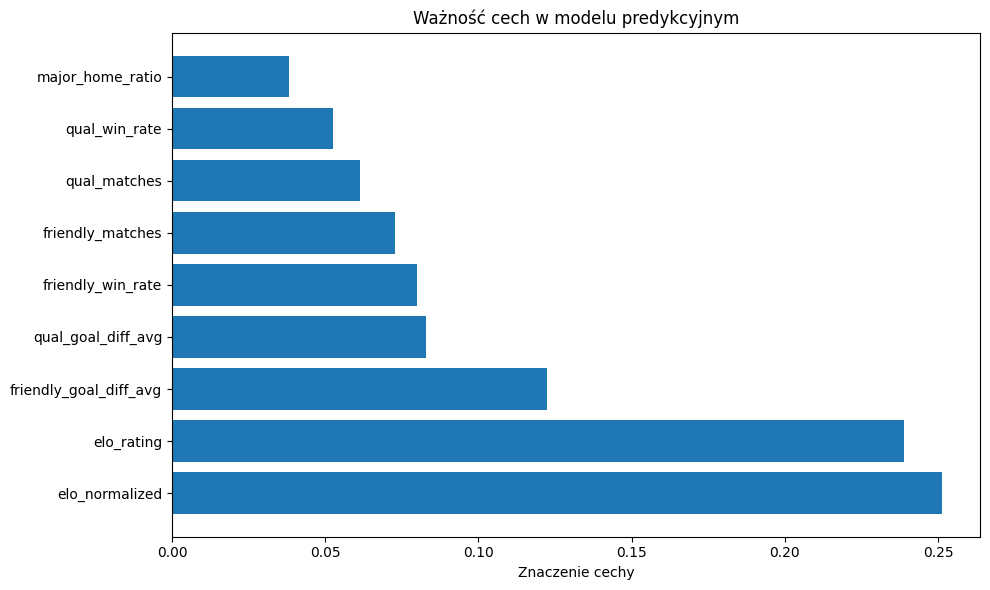

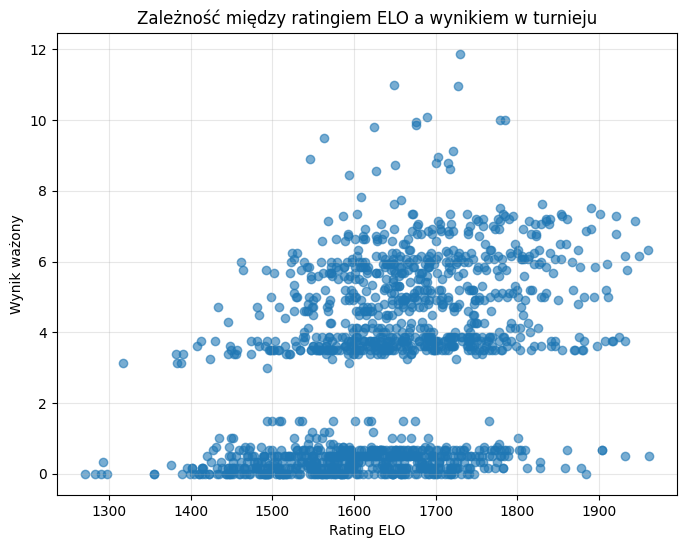

In [9]:
# -*- coding: utf-8 -*-
"""Untitled1.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1JHIKvOEkHvAWK32ntv4TA2Ne-p-dJxiU
"""

# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Na początku pliku, zaraz po importach - dodać funkcję do logowania
import logging

# Konfiguracja logowania
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger('football_analysis')

# Funkcja do bezpiecznego wykonywania kodu
def safe_operation(operation, default_value=None, error_message="Błąd operacji"):
    try:
        return operation()
    except Exception as e:
        logger.error(f"{error_message}: {str(e)}")
        return default_value

# 1. Load mapping and data
# Zakładamy, że pliki są w tym samym katalogu
mapping = pd.read_csv('/content/former_names.csv')  # Zmienione ścieżki do plików
df = pd.read_csv('/content/results.csv')

# 2. Unify names
former_to_current = dict(zip(mapping['former'], mapping['current']))
def unify(name):
    return former_to_current.get(name, name) if isinstance(name, str) else name
for col in ['home_team', 'away_team', 'country']:
    if col in df.columns:  # Sprawdzenie czy kolumna istnieje
        df[col] = df[col].apply(unify)

# 3. Convert types
# 3.1 neutral bool to int - sprawdzamy czy kolumna istnieje
if 'neutral' in df.columns:
    df['isNeutral'] = df['neutral'].astype(int)
else:
    # Jeśli kolumna nie istnieje, zakładamy wartość domyślną
    df['isNeutral'] = 0

# 3.2 date and year
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')
# Obsługa błędnych dat
df = df.dropna(subset=['date'])  # Usunięcie wierszy z błędnymi datami
df['year'] = df['date'].dt.year

# 4. Mark tournaments
# Bezpieczna korekta kodowania
if 'tournament' in df.columns:
    df['tournament'] = df['tournament'].astype(str)
    df['tournament'] = df['tournament'].str.replace('Copa AmÃ©rica', 'Copa América', regex=False)
    final_wc     = ["FIFA World Cup"]
    final_euro   = ["UEFA Euro"]
    final_amer   = ["Copa América"]
    final_africa = ["African Cup of Nations"]
    final_asia   = ["AFC Asian Cup"]
    # flags
    df['is_friendly'] = (df['tournament'] == 'Friendly').astype(int)
    majors_list = final_wc + final_euro + final_amer + final_africa + final_asia
    df['is_major'] = df['tournament'].isin(majors_list).astype(int)
else:
    print("Uwaga: Brak kolumny 'tournament'. Dodawanie domyślnych wartości.")
    df['tournament'] = 'Unknown'
    df['is_friendly'] = 0
    df['is_major'] = 0

# ---------------------
# ELO RATING IMPLEMENTATION
# ---------------------

# Funkcja do obliczania ELO ratingów
def calculate_elo_ratings(matches_df, initial_rating=1500, k_factor=20):
    """
    Oblicza rating ELO dla wszystkich drużyn na podstawie historycznych wyników meczów.

    Args:
        matches_df: DataFrame z meczami, musi zawierać kolumny 'date', 'home_team', 'away_team',
                   'home_score', 'away_score'
        initial_rating: Początkowy rating dla drużyn (domyślnie 1500)
        k_factor: Współczynnik K decydujący o skali zmian ratingu (domyślnie 20)

    Returns:
        DataFrame z historycznymi ratingami ELO dla każdej drużyny po każdym meczu
        oraz słownik z ostatnimi ratingami dla każdej drużyny
    """
    logger.info("Rozpoczynanie obliczania ratingów ELO dla drużyn...")

    # Sprawdź wymagane kolumny
    required_cols = ['date', 'home_team', 'away_team', 'home_score', 'away_score']
    missing_cols = [col for col in required_cols if col not in matches_df.columns]

    if missing_cols:
        logger.error(f"Brakujące kolumny w danych: {missing_cols}")
        return pd.DataFrame(), {}

    # Posortuj mecze chronologicznie
    matches = matches_df.sort_values('date').copy()

    # Słownik do przechowywania aktualnych ratingów
    ratings = {}

    # Lista do przechowywania historii ratingów
    ratings_history = []

    # Przejdź przez wszystkie mecze
    for i, match in matches.iterrows():
        try:
            # Pobierz nazwy drużyn
            home_team = match['home_team']
            away_team = match['away_team']

            # Sprawdź czy drużyny już mają rating, jeśli nie - przypisz wartość początkową
            if home_team not in ratings:
                ratings[home_team] = initial_rating
            if away_team not in ratings:
                ratings[away_team] = initial_rating

            # Pobierz aktualne ratingi
            home_rating = ratings[home_team]
            away_rating = ratings[away_team]

            # Zapisz rating przed meczem
            ratings_history.append({
                'date': match['date'],
                'team': home_team,
                'rating': home_rating,
                'rating_date': match['date']
            })
            ratings_history.append({
                'date': match['date'],
                'team': away_team,
                'rating': away_rating,
                'rating_date': match['date']
            })

            # Oblicz oczekiwany wynik
            exp_home = 1 / (1 + 10 ** ((away_rating - home_rating) / 400))
            exp_away = 1 - exp_home

            # Określ rzeczywisty wynik
            if match['home_score'] > match['away_score']:
                score_home = 1
                score_away = 0
            elif match['home_score'] < match['away_score']:
                score_home = 0
                score_away = 1
            else:
                score_home = 0.5
                score_away = 0.5

            # Zmodyfikuj współczynnik K dla meczów o różnej randze
            match_k = k_factor
            if 'is_major' in match and match['is_major'] == 1:
                match_k = k_factor * 1.5  # Wyższy współczynnik dla dużych turniejów
            elif 'is_friendly' in match and match['is_friendly'] == 1:
                match_k = k_factor * 0.5  # Niższy współczynnik dla meczów towarzyskich

            # Zaktualizuj ratingi
            new_home_rating = home_rating + match_k * (score_home - exp_home)
            new_away_rating = away_rating + match_k * (score_away - exp_away)

            ratings[home_team] = new_home_rating
            ratings[away_team] = new_away_rating

        except Exception as e:
            logger.error(f"Błąd podczas przetwarzania meczu {i}: {str(e)}")
            continue

    # Utwórz DataFrame z historii ratingów
    ratings_df = pd.DataFrame(ratings_history)
    if not ratings_df.empty:
        # Posortuj dane historyczne
        ratings_df = ratings_df.sort_values(['team', 'date'])

    logger.info(f"Zakończono obliczanie ratingów ELO. Przetworzono {len(matches)} meczów dla {len(ratings)} drużyn.")
    return ratings_df, ratings

# Funkcja do pobierania ratingu ELO dla drużyny na określoną datę
def get_team_elo_rating(team, date, ratings_df, initial_rating=1500):
    """
    Pobiera rating ELO dla drużyny na określoną datę.

    Args:
        team: Nazwa drużyny
        date: Data, na którą chcemy znać rating
        ratings_df: DataFrame z historycznymi ratingami
        initial_rating: Domyślny rating, jeśli drużyna nie ma historii

    Returns:
        Wartość ratingu ELO dla drużyny na podaną datę
    """
    if ratings_df.empty:
        return initial_rating

    # Filtruj rating dla danej drużyny przed podaną datą
    team_ratings = ratings_df[(ratings_df['team'] == team) & (ratings_df['date'] <= date)]

    if team_ratings.empty:
        return initial_rating

    # Zwróć najnowszy rating przed podaną datą
    return team_ratings.iloc[-1]['rating']

# Funkcja do dodawania cech związanych z ELO do zbioru danych
def add_elo_features(dataset, ratings_df, initial_rating=1500):
    """
    Dodaje cechy związane z ratingiem ELO do zbioru danych turnieju.

    Args:
        dataset: DataFrame z danymi turniejowymi
        ratings_df: DataFrame z historycznymi ratingami ELO
        initial_rating: Domyślny rating, jeśli drużyna nie ma historii

    Returns:
        DataFrame z dodanymi cechami ELO
    """
    logger.info("Dodawanie cech ELO do zbioru danych...")

    if dataset.empty:
        logger.warning("Pusty zbiór danych, nie można dodać cech ELO")
        return dataset

    # Sprawdź, czy mamy wymagane kolumny
    if not all(col in dataset.columns for col in ['team', 'year']):
        logger.error("Brak wymaganych kolumn 'team' lub 'year' w zbiorze danych")
        return dataset

    # Utwórz kopię zbioru danych
    result = dataset.copy()

    # Dodaj kolumnę z ratingiem ELO
    result['elo_rating'] = result.apply(
        lambda row: get_team_elo_rating(
            row['team'],
            pd.Timestamp(int(row['year']), 6, 1),  # Przyjmujemy 1 czerwca jako datę rozpoczęcia turnieju
            ratings_df,
            initial_rating
        ),
        axis=1
    )

    # Oblicz statystyki ratingu ELO per turniej
    if len(result) > 0:
        yearly_stats = result.groupby('year')['elo_rating'].agg(['mean', 'std']).reset_index()
        yearly_stats = yearly_stats.rename(columns={'mean': 'elo_mean', 'std': 'elo_std'})

        # Dołącz statystyki roczne
        result = pd.merge(result, yearly_stats, on='year', how='left')

        # Oblicz znormalizowany rating ELO
        result['elo_normalized'] = result.apply(
            lambda row: (row['elo_rating'] - row['elo_mean']) / row['elo_std'] if row['elo_std'] > 0 else 0,
            axis=1
        )

    logger.info(f"Zakończono dodawanie cech ELO. Dodano cechy dla {len(result)} rekordów.")
    return result

# Główna funkcja do obliczania i dodawania ELO do analizy
def add_elo_to_analysis(df, dataset_adv, initial_rating=1500, k_factor=20):
    """
    Główna funkcja integrująca ELO z analizą.

    Args:
        df: DataFrame z wszystkimi meczami
        dataset_adv: DataFrame z danymi do analizy
        initial_rating: Początkowy rating ELO
        k_factor: Współczynnik K dla ratingu ELO

    Returns:
        DataFrame z dodanymi cechami ELO
    """
    logger.info("Rozpoczynanie integracji ELO z analizą...")

    # Oblicz ratingi ELO dla wszystkich drużyn
    ratings_df, final_ratings = calculate_elo_ratings(df, initial_rating, k_factor)

    # Wyświetl TOP 10 drużyn według ratingu ELO
    if ratings_df.empty:
        logger.warning("Brak danych do obliczenia ratingu ELO")
    else:
        # Pobierz ostatni rating dla każdej drużyny
        latest_ratings = ratings_df.sort_values('date').groupby('team').last()['rating']
        top_teams = latest_ratings.sort_values(ascending=False).head(10)

        print("\nTOP 10 drużyn według ratingu ELO:")
        for team, rating in top_teams.items():
            print(f"{team}: {rating:.1f}")

    # Dodaj cechy ELO do zbioru danych
    dataset_with_elo = add_elo_features(dataset_adv, ratings_df, initial_rating)

    logger.info("Zakończono integrację ELO z analizą.")
    return dataset_with_elo

# ---------------------
# KONIEC IMPLEMENTACJI ELO
# ---------------------

# 5. Compute aggregate outcomes
majors = df[df['is_major'] == 1].copy()
print(f"Liczba meczów w turniejach rangi mistrzowskiej: {len(majors)}")

# Sprawdź wymagane kolumny
required_cols = ['home_team', 'away_team', 'home_score', 'away_score', 'date']
missing_cols = [col for col in required_cols if col not in majors.columns]
if missing_cols:
    print(f"UWAGA: Brakujące kolumny w danych: {missing_cols}")
    # Dodanie brakujących kolumn z domyślnymi wartościami
    for col in missing_cols:
        if col in ['home_score', 'away_score']:
            majors[col] = 0
        elif col in ['home_team', 'away_team']:
            majors[col] = 'Unknown'
        elif col == 'date':
            majors[col] = pd.Timestamp('2000-01-01')
    print("Dodano brakujące kolumny z wartościami domyślnymi.")

# helper to compute outcome - sprawdzamy czy kolumny istnieją
def compute_outcome(row, side):
    opp = 'away' if side == 'home' else 'home'
    side_score_col = f'{side}_score'
    opp_score_col = f'{opp}_score'
    side_team_col = f'{side}_team'

    # Sprawdzenie, czy kolumny istnieją
    if side_score_col not in row or opp_score_col not in row or side_team_col not in row:
        return pd.Series({
            'team': 'Unknown',
            'year': row.get('year', np.nan),
            'points': 0,
            'win': 0,
            'draw': 0,
            'loss': 0,
            'goals_for': 0,
            'goals_against': 0
        })

    gf = row[side_score_col]
    ga = row[opp_score_col]

    # Walidacja wyników
    try:
        gf = int(gf)
        ga = int(ga)
    except (ValueError, TypeError):
        gf = 0
        ga = 0

    pts = 3 if gf > ga else (1 if gf == ga else 0)
    w = int(gf > ga)
    d = int(gf == ga)
    l = int(gf < ga)

    return pd.Series({
        'team': row[side_team_col],
        'year': row.get('year', np.nan),
        'points': pts,
        'win': w,
        'draw': d,
        'loss': l,
        'goals_for': gf,
        'goals_against': ga
    })

# Sprawdzenie, czy majors ma dane
if not majors.empty:
    home_stats = majors.apply(lambda r: compute_outcome(r, 'home'), axis=1)
    away_stats = majors.apply(lambda r: compute_outcome(r, 'away'), axis=1)
    team_matches = pd.concat([home_stats, away_stats], ignore_index=True)

    # Usunięcie wierszy z brakującymi datami lub zespołami
    team_matches = team_matches.dropna(subset=['year', 'team'])
    team_matches['year'] = team_matches['year'].astype(int)

    agg = team_matches.groupby(['team', 'year']).agg(
        matches_played=('points', 'size'),
        wins=('win', 'sum'),
        draws=('draw', 'sum'),
        losses=('loss', 'sum'),
        total_points=('points', 'sum'),
        goals_for=('goals_for', 'sum'),
        goals_against=('goals_against', 'sum')
    ).reset_index()

    agg['avg_points'] = agg['total_points'] / agg['matches_played']
    agg['goal_diff'] = agg['goals_for'] - agg['goals_against']

    # 6. Weighted target
    agg['advance'] = (agg['matches_played'] > 3).astype(int)
    agg['depth'] = (agg['matches_played'] - 3).clip(lower=0)
    w1, w2, w3 = 2.0, 1.0, 0.5
    # Zapisujemy obliczanie ważonego wyniku w bezpieczny sposób
    try:
        agg['weighted_score'] = w1*agg['advance'] + w2*agg['depth'] + w3*agg['avg_points']
        # Sprawdzamy czy kolumna została prawidłowo utworzona
        if 'weighted_score' in agg.columns:
            print(f"Kolumna 'weighted_score' została pomyślnie utworzona. Przykładowe wartości: {agg['weighted_score'].head(3).tolist()}")
        else:
            print("Błąd: Kolumna 'weighted_score' nie została utworzona mimo braku błędów!")
    except Exception as e:
        print(f"Błąd podczas tworzenia kolumny 'weighted_score': {e}")
        # Tworzenie alternatywnej wersji
        agg['weighted_score'] = agg['matches_played'] * 0.5
else:
    print("Brak danych o turniejach rangi mistrzowskiej!")
    # Tworzenie pustej ramki danych agg do dalszego użycia
    agg = pd.DataFrame(columns=['team', 'year', 'matches_played', 'wins', 'draws',
                                'losses', 'total_points', 'goals_for', 'goals_against',
                                'avg_points', 'goal_diff', 'advance', 'depth', 'weighted_score'])

# 7. Feature engineering - friendlies
friendlies = df[df['is_friendly'] == 1].copy()

def expand_outcome_with_date(row, side):
    s = compute_outcome(row, side)
    s['date'] = row['date']
    return s

if not friendlies.empty:
    home_f = friendlies.apply(lambda r: expand_outcome_with_date(r, 'home'), axis=1)
    away_f = friendlies.apply(lambda r: expand_outcome_with_date(r, 'away'), axis=1)
    fr_exp = pd.concat([home_f, away_f], ignore_index=True)

    # Usunięcie wierszy z brakującymi datami
    fr_exp = fr_exp.dropna(subset=['date', 'team', 'year'])

    def get_friendly_stats(team, year):
        if pd.isna(year):
            return pd.Series({
                'friendly_matches': 0,
                'friendly_win_rate': np.nan,
                'friendly_goal_diff_avg': np.nan
            })

        year = int(year)
        start = pd.Timestamp(year-1, 6, 1)
        end = pd.Timestamp(year, 6, 1)

        df_f = fr_exp[(fr_exp['team']==team) &
                       (fr_exp['date']>=start) &
                       (fr_exp['date']<end)]

        if df_f.empty:
            return pd.Series({
                'friendly_matches': 0,
                'friendly_win_rate': np.nan,
                'friendly_goal_diff_avg': np.nan
            })

        return pd.Series({
            'friendly_matches': len(df_f),
            'friendly_win_rate': df_f['win'].sum() / len(df_f),
            'friendly_goal_diff_avg': (df_f['goals_for'] - df_f['goals_against']).mean()
        })

    if not agg.empty:
        fr_feats = agg.apply(lambda r: get_friendly_stats(r['team'], r['year']), axis=1)
        dataset = pd.concat([agg, fr_feats], axis=1)
        # Bezpieczniejsze usuwanie wierszy z brakującymi wartościami
        dataset = dataset.dropna(subset=['friendly_win_rate'])
    else:
        print("Brak danych agregacyjnych dla turniejów!")
        dataset = pd.DataFrame()
else:
    print("Brak danych o meczach towarzyskich!")
    dataset = agg.copy() if not agg.empty else pd.DataFrame()
    # Dodanie pustych kolumn dla danych o meczach towarzyskich
    for col in ['friendly_matches', 'friendly_win_rate', 'friendly_goal_diff_avg']:
        dataset[col] = np.nan

# 8. Feature engineering - qualifiers
quals = df[df['tournament'].str.lower().str.contains('qualification', na=False)].copy()

if not quals.empty and not dataset.empty:
    home_q = quals.apply(lambda r: expand_outcome_with_date(r, 'home'), axis=1)
    away_q = quals.apply(lambda r: expand_outcome_with_date(r, 'away'), axis=1)
    ql_exp = pd.concat([home_q, away_q], ignore_index=True)

    # Usunięcie wierszy z brakującymi datami
    ql_exp = ql_exp.dropna(subset=['date', 'team', 'year'])

    def get_qual_stats(team, year):
        if pd.isna(year):
            return pd.Series({
                'qual_matches': 0,
                'qual_win_rate': np.nan,
                'qual_goal_diff_avg': np.nan
            })

        year = int(year)
        start = pd.Timestamp(year-1, 6, 1)
        end = pd.Timestamp(year, 6, 1)

        df_q = ql_exp[(ql_exp['team']==team) &
                       (ql_exp['date']>=start) &
                       (ql_exp['date']<end)]

        if df_q.empty:
            return pd.Series({
                'qual_matches': 0,
                'qual_win_rate': np.nan,
                'qual_goal_diff_avg': np.nan
            })

        return pd.Series({
            'qual_matches': len(df_q),
            'qual_win_rate': df_q['win'].sum() / len(df_q),
            'qual_goal_diff_avg': (df_q['goals_for'] - df_q['goals_against']).mean()
        })

    ql_feats = dataset.apply(lambda r: get_qual_stats(r['team'], r['year']), axis=1)
    dataset_ext = pd.concat([dataset, ql_feats], axis=1)

    # Bardziej elastyczne filtrowanie - nie wymagamy obu cech jednocześnie
    dataset_ext = dataset_ext.fillna({
        'qual_win_rate': 0,
        'qual_goal_diff_avg': 0,
        'qual_matches': 0
    })
else:
    print("Brak danych o meczach kwalifikacyjnych lub pustych danych agregacyjnych!")
    dataset_ext = dataset.copy() if not dataset.empty else pd.DataFrame()
    # Dodanie pustych kolumn dla danych o meczach kwalifikacyjnych
    for col in ['qual_matches', 'qual_win_rate', 'qual_goal_diff_avg']:
        dataset_ext[col] = 0

# 9. Home advantage for majors
majors = df[df['is_major']==1].copy()

if not majors.empty and not dataset_ext.empty:
    majors['year'] = majors['date'].dt.year

    def outcome_with_side(row, side):
        s = compute_outcome(row, side)
        if row['isNeutral'] == 1:
            s['match_type'] = 'neutral'
        else:
            s['match_type'] = 'home' if side=='home' else 'away'
        return s

    # Expand each major match into per-team records with match_type
    home_records = majors.apply(lambda r: outcome_with_side(r, 'home'), axis=1)
    away_records = majors.apply(lambda r: outcome_with_side(r, 'away'), axis=1)

    # Convert home_records and away_records DataFrames to list of dicts and concatenate
    all_records = home_records.to_dict('records') + away_records.to_dict('records')
    maj_exp = pd.DataFrame(all_records)

    # Sprawdzenie czy maj_exp ma dane
    if not maj_exp.empty and 'match_type' in maj_exp.columns:
        # Usunięcie wierszy z brakującymi danymi
        maj_exp = maj_exp.dropna(subset=['team', 'year', 'match_type'])

        # Aggregate home/away/neutral counts
        home_stats = maj_exp.groupby(['team','year'])['match_type'] \
            .value_counts().unstack(fill_value=0).reset_index()

        # Sprawdzenie czy kolumny istnieją
        for col in ['home', 'away', 'neutral']:
            if col not in home_stats.columns:
                home_stats[col] = 0

        # Rename columns
        home_stats = home_stats.rename(columns={
            'home': 'major_home_matches',
            'away': 'major_away_matches',
            'neutral': 'major_neutral_matches'
        })

        # Compute ratio
        home_stats['major_total_matches'] = (
            home_stats['major_home_matches'] +
            home_stats['major_away_matches'] +
            home_stats['major_neutral_matches']
        )

        # Unikanie dzielenia przez zero
        home_stats['major_home_ratio'] = np.where(
            home_stats['major_total_matches'] > 0,
            home_stats['major_home_matches'] / home_stats['major_total_matches'],
            0
        )

        # Merge into dataset_ext
        dataset_adv = pd.merge(
            dataset_ext,
            home_stats[['team','year','major_home_ratio']],
            on=['team','year'],
            how='left'
        ).fillna({'major_home_ratio': 0})
    else:
        print("Brak danych o typach meczów!")
        dataset_adv = dataset_ext.copy()
        dataset_adv['major_home_ratio'] = 0
else:
    print("Brak danych o meczach w turniejach głównych lub pustych danych rozszerzonych!")
    dataset_adv = dataset_ext.copy() if not dataset_ext.empty else pd.DataFrame()
    dataset_adv['major_home_ratio'] = 0

# Dodanie ELO do analizy - integracja z dotychczasowym kodem
dataset_with_elo = add_elo_to_analysis(df, dataset_adv, initial_rating=1500, k_factor=20)

# 10. Define features - dodanie cech ELO
feature_cols = [
    'friendly_matches', 'friendly_win_rate', 'friendly_goal_diff_avg',
    'qual_matches', 'qual_win_rate', 'qual_goal_diff_avg'
]
feature_cols_adv = feature_cols + ['major_home_ratio']

# Dodanie cech ELO do zbioru cech
if 'elo_rating' in dataset_with_elo.columns:
    feature_cols_with_elo = feature_cols_adv + ['elo_rating', 'elo_normalized']
    print("\nDodano cechy ELO do zestawu cech!")
else:
    feature_cols_with_elo = feature_cols_adv
    print("\nBrak cech ELO w zbiorze danych.")

# 11. Prepare dataset_score
if not dataset_with_elo.empty and not agg.empty:
    # Sprawdzenie czy 'weighted_score' jest w agg
    if 'weighted_score' not in agg.columns:
        print("Kolumna 'weighted_score' nie istnieje w danych agregacyjnych!")
        print("Dodawanie kolumny 'weighted_score' na podstawie dostępnych danych...")
        # Próba odtworzenia weighted_score z dostępnych danych
        if all(col in agg.columns for col in ['advance', 'depth', 'avg_points']):
            w1, w2, w3 = 2.0, 1.0, 0.5
            agg['weighted_score'] = w1*agg['advance'] + w2*agg['depth'] + w3*agg['avg_points']
        else:
            # Jeśli nie ma potrzebnych kolumn, tworzymy prostszą wersję
            print("Brak wymaganych kolumn do obliczenia 'weighted_score'!")
            if 'matches_played' in agg.columns:
                agg['weighted_score'] = agg['matches_played'] * 0.5
            else:
                # Ostateczne rozwiązanie - wartość domyślna
                agg['weighted_score'] = 1.0
            print("Utworzono zastępczą kolumnę 'weighted_score' z wartościami domyślnymi.")

    # Wyświetlenie dostępnych kolumn dla diagnostyki
    print("Kolumny w agg:", agg.columns.tolist())

    dataset_score = pd.merge(
        dataset_with_elo,
        agg[['team', 'year', 'weighted_score']],
        on=['team', 'year'],
        how='inner'
    )

    # Sprawdzenie połączonego zbioru danych
    print(f"Rozmiar dataset_score po połączeniu: {len(dataset_score)}")
    print("Kolumny w dataset_score:", dataset_score.columns.tolist())

    # Sprawdzenie połączonego zbioru danych i rozwiązanie problemu z weighted_score
    if 'weighted_score' not in dataset_score.columns:
        print("UWAGA: Brak kolumny 'weighted_score' w dataset_score po połączeniu!")
        print("Próba bezpośredniego dodania kolumny...")

        # Próba rozwiązania problemu z brakującą kolumną weighted_score
        if 'team' in dataset_score.columns and 'year' in dataset_score.columns:
            # Utwórz słownik mapujący (team, year) na weighted_score
            score_dict = {}
            for _, row in agg.iterrows():
                if 'weighted_score' in row:
                    score_dict[(row['team'], row['year'])] = row['weighted_score']

            # Zastosuj mapowanie do dataset_score
            dataset_score['weighted_score'] = dataset_score.apply(
                lambda r: score_dict.get((r['team'], r['year']), 1.0), axis=1
            )
            print(f"Dodano kolumnę 'weighted_score' z {len(score_dict)} mapowań.")
        else:
            # Jeśli nie można utworzyć mapowania, dodaj stałą wartość
            dataset_score['weighted_score'] = 1.0
            print("Dodano kolumnę 'weighted_score' z wartością domyślną 1.0")

    # Sprawdzenie, czy mamy wystarczającą liczbę danych do modelowania
    if len(dataset_score) >= 10 and all(col in dataset_score.columns for col in feature_cols_with_elo + ['weighted_score']):
        # 12. Train/evaluate weighted target model
        X = dataset_score[feature_cols_with_elo]
        y = dataset_score['weighted_score']

        # Upewnienie się, że X nie ma brakujących danych
        X = X.fillna(0)

        # Sprawdzenie czy X ma wystarczający rozmiar
        if len(X) >= 10:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            # Upewnienie się, że zbiory treningowe i testowe nie są puste
            if len(X_train) > 0 and len(X_test) > 0:
                pipe_ws = Pipeline([
                    ('scaler', StandardScaler()),
                    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
                ])

                pipe_ws.fit(X_train, y_train)
                y_pred = pipe_ws.predict(X_test)
                print(f"Weighted target → MAE: {mean_absolute_error(y_test, y_pred):.3f}, "
                      f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}, "
                      f"R²: {r2_score(y_test, y_pred):.3f}")

                # 13. Compare simple model
                lin = make_pipeline(StandardScaler(), LinearRegression())
                lin.fit(X_train, y_train)
                y_lin = lin.predict(X_test)
                print(f"Linear MAE: {mean_absolute_error(y_test, y_lin):.3f}, "
                      f"RMSE: {np.sqrt(mean_squared_error(y_test, y_lin)):.3f}, "
                      f"R²: {r2_score(y_test, y_lin):.3f}")

                # Wyświetl ważność cech w modelu
                feature_importance = pd.DataFrame({
                    'Feature': feature_cols_with_elo,
                    'Importance': pipe_ws.named_steps['model'].feature_importances_
                }).sort_values('Importance', ascending=False)

                print("\nWażność cech w modelu z ELO:")
                print(feature_importance)

                # Wizualizacja ważności cech
                plt.figure(figsize=(10, 6))
                plt.barh(feature_importance['Feature'], feature_importance['Importance'])
                plt.xlabel('Znaczenie cechy')
                plt.title('Ważność cech w modelu predykcyjnym')
                plt.tight_layout()
                plt.savefig('feature_importance.png')  # Zapisanie wykresu
                print("Zapisano wykres ważności cech jako 'feature_importance.png'")

                # Przykładowa analiza predykcji
                print("\nPrzykłady predykcji dla zespołów:")
                sample_teams = dataset_score.sample(min(5, len(dataset_score)))
                for _, row in sample_teams.iterrows():
                    team = row['team']
                    year = row['year']
                    actual = row['weighted_score']
                    features = row[feature_cols_with_elo].values.reshape(1, -1)
                    predicted = pipe_ws.predict(features)[0]
                    print(f"{team} ({int(year)}): Prognoza: {predicted:.2f}, Rzeczywisty: {actual:.2f}")

                # Analiza zależności od ratingu ELO, jeśli jest dostępny
                if 'elo_rating' in dataset_score.columns:
                    plt.figure(figsize=(8, 6))
                    plt.scatter(dataset_score['elo_rating'], dataset_score['weighted_score'], alpha=0.6)
                    plt.xlabel('Rating ELO')
                    plt.ylabel('Wynik ważony')
                    plt.title('Zależność między ratingiem ELO a wynikiem w turnieju')
                    plt.grid(True, alpha=0.3)
                    plt.savefig('elo_vs_performance.png')
                    print("Zapisano wykres zależności ELO od wyników jako 'elo_vs_performance.png'")
            else:
                print("Zbyt mało danych po podziale na zbiory treningowy i testowy!")
        else:
            print("Zbyt mało danych do trenowania modelu!")
    else:
        print("Brak wystarczającej liczby danych lub brakujące kolumny cech!")
else:
    print("Brak danych do trenowania modelu!")